# Solving a QUBO using VQE in qiskit

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

import sys
sys.path.append('../utils/')
import qubo_utils as qutils 

In [2]:
# The 3D-RISM density slices are saved as pickled files in the folder MUP1.
# They are indexed by a number (see d_list) which represents the distance in Angstrom
# from the central slice.

d_list = [-1.0, -0.5, 0.0, 0.5, 1.0, 1.5]

# import slices
path = "../MUP1/MUP1_logfilter8_slices/"
basename = "_density_slice_MUP1_logfilter8.p"
densities = qutils.density_slices(d_list=d_list, basename=basename, path=path)

# import slice coordinates (these are 3D coordinates in
# angstroms, they are needed at the very end to map
# excited qubits to positions in the protein cavity)
path = "../MUP1/MUP1_logfilter8_points/"
basename = "_plane_points_MUP1.p"
points = qutils.plane_points(d_list=d_list, basename=basename, path=path)

# The register associated to each slide can be found in the folder nb/registers.
# Two types of files are saved there:
# - position_<#>.npy: the positions of the qubits in micrometers, as if they were in the QPU
# - rescaled_position_<#>.npy: the positions of the qubits on the same scale as the density slices

# import registers
path = "registers/"
basename = "position_"
positions = qutils.register_positions(d_list=d_list, basename=basename, path=path)

basename = "rescaled_position_"
rescaled_positions = qutils.rescaled_positions(d_list=d_list, basename=basename, path=path)

In [4]:
from qiskit_algorithms.optimizers import COBYLA, L_BFGS_B, SLSQP
from qiskit.circuit.library import TwoLocal
from qiskit.primitives import Estimator
from qiskit_algorithms.minimum_eigensolvers import VQE

from qiskit import transpile 
from qiskit import Aer

from qiskit_algorithms.utils import algorithm_globals

# for reproducable results
algorithm_globals.random_seed = 3

# compute the qubo matrix for each slice
qubo_matrices = qutils.get_qubo_matrices(densities=densities, rescaled_positions=rescaled_positions)

We pick a qubo matrix and apply VQE to solve it using a few different optimizers.

In [5]:
qubo = qubo_matrices[0] # use the first slice as an example to solve

# get the corresponding Ising Hamiltonian
ising_ham = qutils.get_Ising_hamiltonian(qubo=qubo)

# number of qubits for the ansatz is equal to the size of the qubo matrix
num_qubits = len(qubo)

# optimizers to be used
optimizers = [COBYLA(maxiter=80), L_BFGS_B(maxiter=60), SLSQP(maxiter=60)]
converge_counts = np.empty([len(optimizers)], dtype=object)
converge_vals = np.empty([len(optimizers)], dtype=object)

In [11]:
estimator = Estimator()
backend = Aer.get_backend('aer_simulator')

for i, optimizer in enumerate(optimizers):
    # define the ansatz to be used in vqe
    ansatz = TwoLocal(num_qubits, 'ry', 'cz')

    counts = []
    values = []

    # a callback function for the vqe
    def store_intermediate_result(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)

    # intialize vqe instance
    vqe = VQE(estimator, ansatz, optimizer, callback=store_intermediate_result)

    result = vqe.compute_minimum_eigenvalue(operator=ising_ham)
    converge_counts[i] = np.asarray(counts)
    converge_vals[i] = np.asarray(values)
  
    opt_params = result.optimal_point
    qc = ansatz.assign_parameters(opt_params)

    
    # First we have to transpile the quantum circuit 
    # to the low-level QASM instructions used by the 
    # backend
    qc_compiled = transpile(qc, backend)
    qc_compiled.measure_active()

    # Execute the circuit on the qasm simulator.
    # We've set the number of repeats of the circuit
    # to be 1024, which is the default.
    job_sim = backend.run(qc_compiled, shots=1024)

    # Grab the results from the job.
    result_sim = job_sim.result()
    msrmnts = result_sim.get_counts()
    #print(msrmnts)

    # since bits are flipped, the solution is
    sol = qutils.get_most_likely(msrmnts=msrmnts)
    energy = qutils.Ising_energy(assignment=sol, qubo=qubo)

    print(f"solution {sol} with energy {energy:.5f}")


solution [1, 0, 0, 0] with energy -0.01074
solution [1, 0, 0, 0] with energy -0.01074
solution [0, 0, 0, 1] with energy -0.00969


The ansatz circuit. It consists of 16 single qubit gates (which is also equal to the number of parameters) and 3 layers of full entanglement blocks.

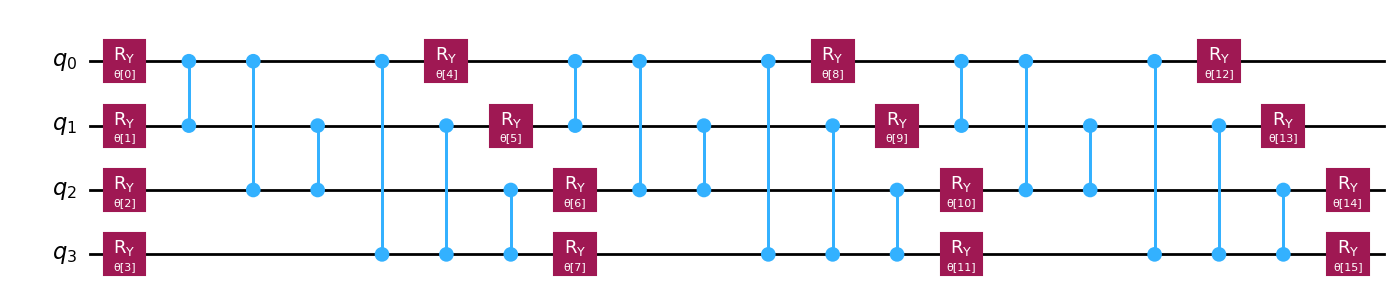

In [7]:
ansatz.decompose().draw('mpl', style='iqx')

In [8]:
# classical brute-force solution
_, ref_value = qutils.find_optimum(qubo=qubo)

In the following, we plot the convergence of the energy in each VQE step for each optimizer. The y-axis is the absolute value of the difference between the VQE and the true minimum energy. The x-axis is the number of evaluations of the circuit.

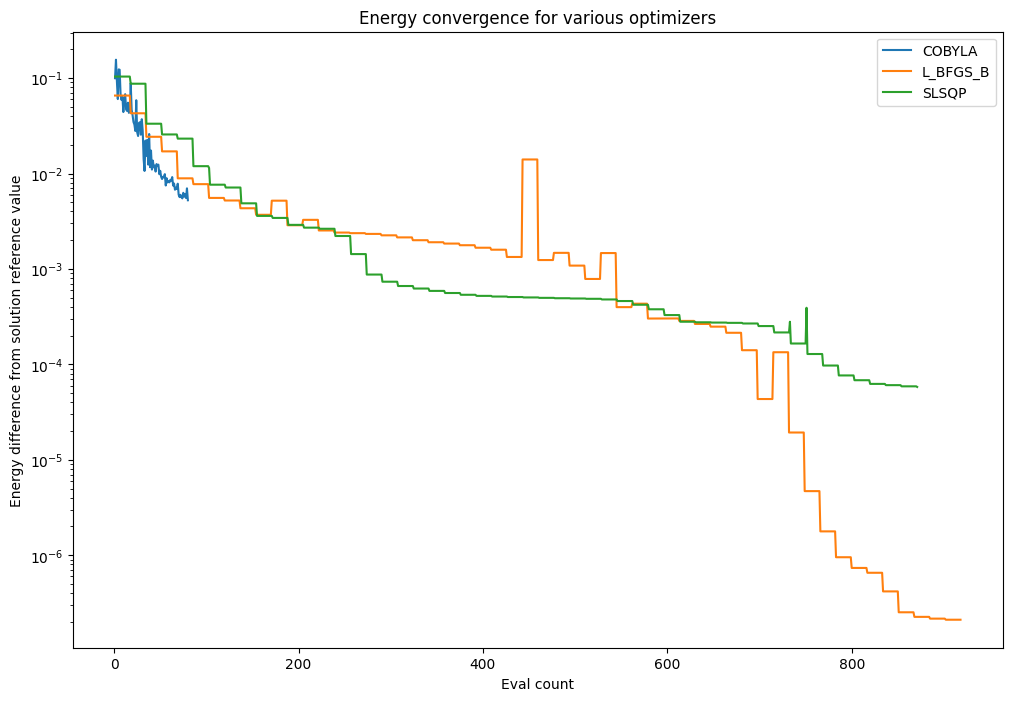

In [9]:
import pylab

pylab.rcParams["figure.figsize"] = (12, 8)
for i, optimizer in enumerate(optimizers):
    pylab.plot(
        converge_counts[i],
        abs(ref_value - converge_vals[i]),
        label=type(optimizer).__name__,
    )
#pylab.plot(range(1200), [10**(-3)]*1200, label="error threshold")
pylab.xlabel("Eval count")
pylab.ylabel("Energy difference from solution reference value")
pylab.title("Energy convergence for various optimizers")
pylab.yscale("log")
pylab.legend(loc="upper right");

## Resource estimation

In [12]:
num_single_qubit_gates = ansatz.num_parameters
num_single_qubit_gates

16